# Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
import os

from sklearn.model_selection import train_test_split
from scipy.stats import beta

# Step 1: Get the prior data from before

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
def transform_values(i,n,prior=1/2):
    return (i*(n-1)+prior)/n

In [7]:
prior_a, prior_b, loc, scale = beta.fit([transform_values(i, len(train_videos.values),1/2)
                                          for i in train_videos.values], floc=0, fscale=1)

In [8]:
prior_a *= 10
prior_b *= 10
print(prior_a, prior_b)

14.270965891341989 5.916156493565227


# Step 2: Load in the kuairec test dataset in case we need it

In [9]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [10]:
num_samples = 100

In [11]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [12]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [13]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[0, num_samples//4, 2*num_samples//4, 3*num_samples//4, -2, -1]].keys())
videos_of_interest

[9136, 9885, 6172, 7257, 2687, 7076]

In [14]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

# Step 3: Load in simulation data

In [15]:
data_dict = dict()
for val in [0.0, 0.3, 0.7, 1.0]:
    data_dict[val] = np.load(f'soal_sims/sim_data_alpha_{val}.npy',allow_pickle=True)[()]

In [16]:
data_dict[0.0].keys()

dict_keys([10328, 1351, 6757, 1095, 4028, 8915, 4706, 4443, 7039, 6763, 1299, 7227, 8475, 6259, 8359, 6293, 4158, 4685, 9736, 3191, 4659, 2365, 10257, 701, 2475, 10462, 5596, 5448, 7226, 4556, 2559, 2578, 7695, 7293, 3064, 3970, 9177, 2029, 2503, 9149, 632, 6788, 937, 4571, 8681, 4041, 5731, 5690, 8736, 3125, 4451, 1170, 423, 2045, 5326, 4131, 9882, 3118, 5612, 9682, 4076, 1439, 589, 1212, 4188, 1386, 7014, 2573, 579, 5535, 3866, 5838, 845, 2575, 9995, 9925, 9102, 5876, 5813, 983, 5537, 8162, 1452, 8629, 10078, 10589, 7109, 7526, 9898, 5865, 2521, 542, 9947, 1126, 4145, 9571, 4554, 6251, 4632, 3082])

In [17]:
data_dict[0.3].keys()

dict_keys([(10328, 0.3), (1351, 0.3), (6757, 0.3), (1095, 0.3), (4028, 0.3), (8915, 0.3), (4706, 0.3), (4443, 0.3), (7039, 0.3), (6763, 0.3), (1299, 0.3), (7227, 0.3), (8475, 0.3), (6259, 0.3), (8359, 0.3), (6293, 0.3), (4158, 0.3), (4685, 0.3), (9736, 0.3), (3191, 0.3), (4659, 0.3), (2365, 0.3), (10257, 0.3), (701, 0.3), (2475, 0.3), (10462, 0.3), (5596, 0.3), (5448, 0.3), (7226, 0.3), (4556, 0.3), (2559, 0.3), (2578, 0.3), (7695, 0.3), (7293, 0.3), (3064, 0.3), (3970, 0.3), (9177, 0.3), (2029, 0.3), (2503, 0.3), (9149, 0.3), (632, 0.3), (6788, 0.3), (937, 0.3), (4571, 0.3), (8681, 0.3), (4041, 0.3), (5731, 0.3), (5690, 0.3), (8736, 0.3), (3125, 0.3), (4451, 0.3), (1170, 0.3), (423, 0.3), (2045, 0.3), (5326, 0.3), (4131, 0.3), (9882, 0.3), (3118, 0.3), (5612, 0.3), (9682, 0.3), (4076, 0.3), (1439, 0.3), (589, 0.3), (1212, 0.3), (4188, 0.3), (1386, 0.3), (7014, 0.3), (2573, 0.3), (579, 0.3), (5535, 0.3), (3866, 0.3), (5838, 0.3), (845, 0.3), (2575, 0.3), (9995, 0.3), (9925, 0.3), (9102

# Step 4: Plotting

## Step 4.1: Sanity checking

### Step 4.1.1 ensure all eb priors are consistent

In [18]:
for k in data_dict:
    if not type(k) == float:
        k = k[0]
    curr_priors = ((1-k)*1.0 + k*prior_a, (1-k)*1.0 + k*prior_b)
    for j in data_dict[k]:
        for arr in data_dict[k][j]:
            if np.round(arr[0,0],5) != np.round(curr_priors[0],5) or np.round(arr[0,1],5) != np.round(curr_priors[1],5):
                print(arr[0])
                print(curr_priors)
                assert False

### Step 4.1.2 ensure that data overwhelms the prior

In [19]:
video_df[data_dict[0.0].keys()].sort_values()

video_id
1170     0.001417
1095     0.017718
8915     0.021277
5596     0.028409
1212     0.045358
           ...   
4659     0.941818
4685     0.946137
3118     0.946137
10462    0.952620
1452     0.956903
Name: liked, Length: 100, dtype: float64

In [20]:
num_quints = 5
cutoff = 80
quantile_df = pd.qcut(video_df,q=num_quints,labels=[1,2,3,4,5])
tracked_prod = 1452

In [21]:
1305 in data_dict[0.0]

False

In [22]:
plot_dict = dict()
count_dict = dict()
for k in data_dict:
    curr_priors = ((1-k)*1.0 + k*prior_a, (1-k)*1.0 + k*prior_b)
    for quint in range(1,num_quints+1):
        plot_dict[(k, quint)] = np.zeros(cutoff)
        count_dict[(k, quint)] = 0
    for l in data_dict[k]:
        if tracked_prod == l or (type(l)==tuple and tracked_prod in l):
            for traj in data_dict[k][l]:
                t = np.unique(traj,axis=0)
                if len(t) >= cutoff:
                    prod_id = l if k==0.0 else l[0]
                    traj_qual = quantile_df[prod_id]
                    plot_dict[(k, traj_qual)] += t[:cutoff,0]/(t[:cutoff,0] + t[:cutoff,1])
                    count_dict[(k, traj_qual)] += 1

for k in count_dict:
    if count_dict[k] != 0:
        plot_dict[k] = plot_dict[k]/count_dict[k]

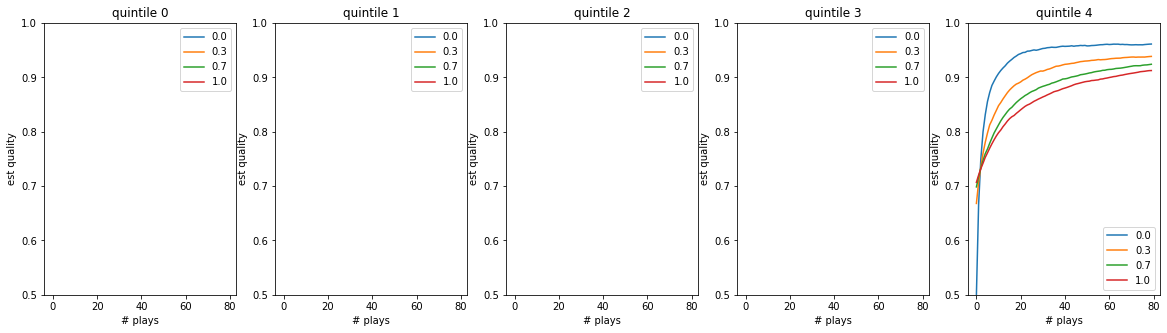

In [23]:
f,axes=plt.subplots(1,5)
f.set_size_inches(20, 5)
for i in range(len(axes)):
    plt.sca(axes[i])
    plt.title(f'quintile {i}')
    plt.ylim((0.5, 1))
    keys = [(k,i+1) for k in data_dict]
    for k in keys:
        plt.plot(plot_dict[k],label=k[0])
    plt.legend()
    plt.xlabel('# plays')
    plt.ylabel('est quality')

In [24]:
plot_dict = dict()
count_dict = dict()
for k in data_dict:
    curr_priors = ((1-k)*1.0 + k*prior_a, (1-k)*1.0 + k*prior_b)
    count_dict[k] = 0
    plot_dict[k] = np.zeros(cutoff)
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            t = np.unique(traj,axis=0)
            if len(t) >= cutoff:
                plot_dict[k] += t[:cutoff,0]/(t[:cutoff,0] + t[:cutoff,1])
                count_dict[k] += 1

for k in count_dict:
    if count_dict[k] != 0:
        plot_dict[k] = plot_dict[k]/count_dict[k]

Text(0, 0.5, 'est quality')

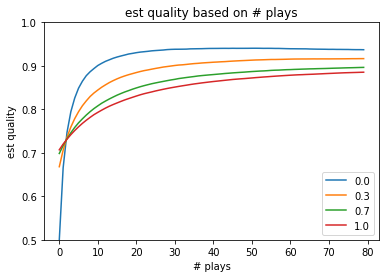

In [25]:
plt.ylim((0.5, 1))
keys = [k for k in data_dict]
for k in keys:
    plt.plot(plot_dict[k],label=k)
plt.legend()
plt.title('est quality based on # plays')
plt.xlabel('# plays')
plt.ylabel('est quality')

## Step 4.2 - how impactful is early performance on later plays?

In [26]:
num_quants = 10
cutoff = 100 # must be greater than or equal to 10

In [27]:
# build the modified data dict from the existing data dict

quantile_df = pd.qcut(video_df,q=num_quants,labels=range(1,num_quants+1))
modified_data_dict = dict()
for k in data_dict:
    d = dict()
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            if traj.shape[0] >= cutoff + 1:
                prod_id = l if k==0.0 else l[0]
                traj_qual = quantile_df[prod_id] # get quality to closest multiple of 0.2
                truncated_traj = copy.deepcopy(traj)[cutoff,:]
                num_likes_at_10 = int(np.sum(traj[10,0]) - np.sum(traj[0,0]))
                num_likes_at_10 = 3 if num_likes_at_10 > 3 else num_likes_at_10
                truncated_traj = np.sum(truncated_traj) - np.sum(traj[0,:])
                if (num_likes_at_10, traj_qual) in d:
                    d[(num_likes_at_10, traj_qual)].append(truncated_traj)
                else:
                    d[(num_likes_at_10,traj_qual)] = [truncated_traj]
                
    modified_data_dict[k] = d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


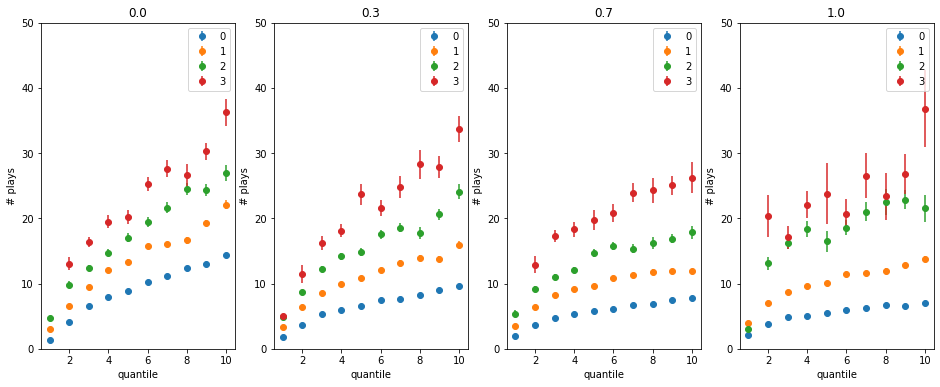

In [28]:
f, axes = plt.subplots(1,4)
f.set_size_inches(16,6)
prior_keys = sorted(list(modified_data_dict.keys()))
# f.suptitle('number of plays conditioned on # of likes in first 10 timesteps',y=0.91)
for i in range(len(axes)):
    plt.sca(axes[i])
    k = prior_keys[i]
    curr_dict = modified_data_dict[k]
    for num_likes in np.unique([a for (a,b) in modified_data_dict[k].keys()]):
#         plt.scatter(x=[b for (a,b) in modified_data_dict[k].keys() if a==num_likes],
#                     y=[np.mean(modified_data_dict[k][(num_likes,b)]) for (a,b) in modified_data_dict[k].keys() if a==num_likes],
#                     label=num_likes)
        plt.errorbar(x=[b for (a,b) in modified_data_dict[k].keys() if a==num_likes],
            y=[np.mean(modified_data_dict[k][(num_likes,b)]) for (a,b) in modified_data_dict[k].keys() if a==num_likes],
            yerr =[scipy.stats.sem(modified_data_dict[k][(num_likes,b)]) for (a,b) in modified_data_dict[k].keys() if a==num_likes],
            fmt='o',
            label=num_likes)
    plt.legend()
    plt.title(k)
    plt.ylim((0,50))
    plt.xlabel('quantile')
    plt.ylabel('# plays')
        

## Step 4.3 - true quality vs. number of plays

In [29]:
quantile_df = pd.cut(video_df, np.linspace(0,1,21), labels=(np.linspace(0,0.95,20) + np.linspace(0.05, 1,20))/2)
cutoff = 60

In [30]:
for k in data_dict:
    d = dict()
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            if traj.shape[0] >= cutoff + 1:
                prod_id = l if k==0.0 else l[0]
                traj_qual = quantile_df[prod_id] # get quality to closest multiple of 0.2
                truncated_traj = copy.deepcopy(traj)[cutoff,:]
                truncated_traj = np.sum(truncated_traj) - np.sum(traj[0,:])
                if traj_qual in d:
                    d[traj_qual].append(truncated_traj)
                else:
                    d[traj_qual] = [truncated_traj]
                
    modified_data_dict[k] = d

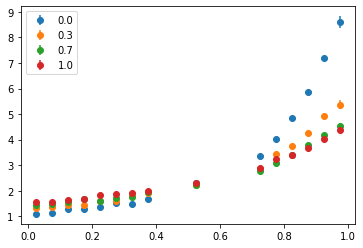

In [31]:
for k in modified_data_dict.keys():
    plt.errorbar(x=list(modified_data_dict[k].keys()),
                 y=[np.mean(modified_data_dict[k][l]) for l in modified_data_dict[k].keys()],
                 yerr=[scipy.stats.sem(modified_data_dict[k][l]) for l in modified_data_dict[k].keys()], # plot std errorbars here!
                 fmt='o',
                 label=k)
    plt.legend()

## Step 4.4: Boxplots demonstrating variance reduction in quality estimation and number of plays when we switch methods

In [32]:
modified_quantile_df = ((quantile_df.astype(float) - 0.025)*20).astype(int)

In [91]:
quality_datapoints_freq = [[] for _ in range(20)]
for l in data_dict[0.0]:
    chosen_vector = quality_datapoints_freq[modified_quantile_df[l]]
        
    for lifespan in data_dict[0.0][l]:
        final_score = lifespan[-1] - lifespan[0]
        if np.sum(final_score) != 0:
            chosen_vector.append(final_score[0]/(final_score[0] + final_score[1]))
    

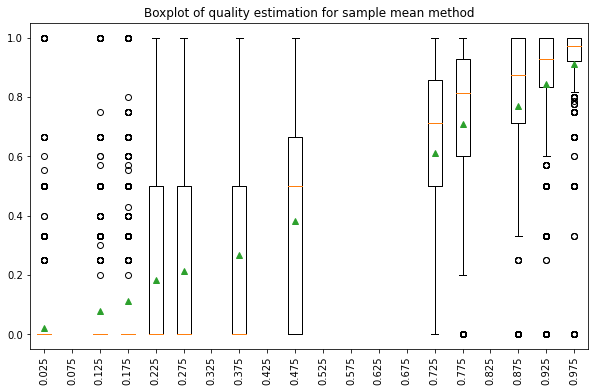

In [92]:
plt.figure(figsize=(10,6))
plt.boxplot(quality_datapoints_freq, labels=sorted(np.round(list(set(quantile_df.values)),3)), showmeans=True)
plt.xticks(rotation='vertical')
plt.title('Boxplot of quality estimation for sample mean method')
_ = plt.show()

In [35]:
plays_datapoints_freq = [[] for _ in range(20)]
for l in data_dict[0.0]:
    chosen_vector = plays_datapoints_freq[modified_quantile_df[l]]
        
    for lifespan in data_dict[0.0][l]:
        final_score = lifespan[-1]
        chosen_vector.append((final_score[0] + final_score[1] - 2)/lifespan.shape[0])
    

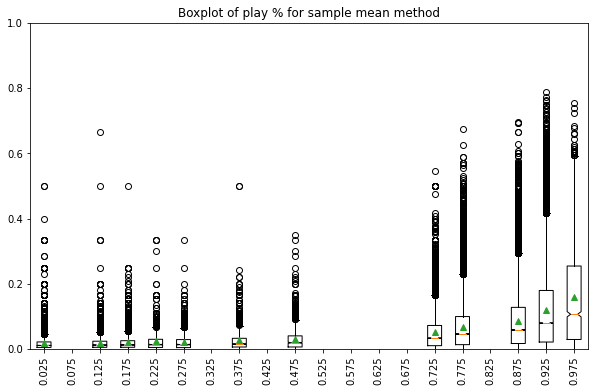

In [36]:
plt.figure(figsize=(10,6))
plt.boxplot(plays_datapoints_freq, labels=sorted(np.round(list(set(quantile_df.values)),3)), notch=True, showmeans=True)
plt.xticks(rotation='vertical')
plt.ylim((0,1))
plt.title('Boxplot of play % for sample mean method')
_ = plt.show()

# do some light filtering of lifespan here to address problems with short lifespan items

In [93]:
quality_datapoints_eb = [[] for _ in range(20)]
for l in data_dict[1.0]:
    chosen_vector = quality_datapoints_eb[modified_quantile_df[l[0]]]
        
    for lifespan in data_dict[1.0][l]:
        final_score = lifespan[-1] - lifespan[0]
        if np.sum(final_score) != 0:
            chosen_vector.append(final_score[0]/(final_score[0] + final_score[1]))
    

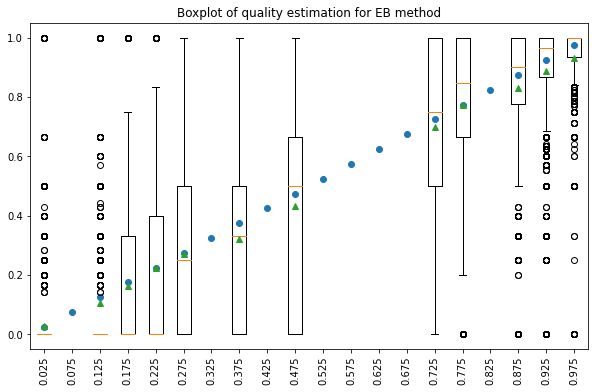

In [121]:
plt.figure(figsize=(10,6))
labels = sorted(np.round(list(set(quantile_df.values)),3))
plt.boxplot(quality_datapoints_eb, labels=labels, showmeans=True)
plt.xticks(rotation='vertical')
plt.title('Boxplot of quality estimation for EB method')
plt.scatter(np.array(labels)*20+0.5, np.array(labels))
_ = plt.show()

# also include a plot of alpha=0.3 or alpha=0.7 to get a middle ground
# change the dataset of the static setting to the KuaiRec dataset!

In [39]:
plays_datapoints_eb = [[] for _ in range(20)]
for l in data_dict[1.0]:
    chosen_vector = plays_datapoints_eb[modified_quantile_df[l[0]]]
        
    for lifespan in data_dict[1.0][l]:
        final_score = lifespan[-1]
        chosen_vector.append((final_score[0] + final_score[1] - np.sum(lifespan[0]))/lifespan.shape[0])
    

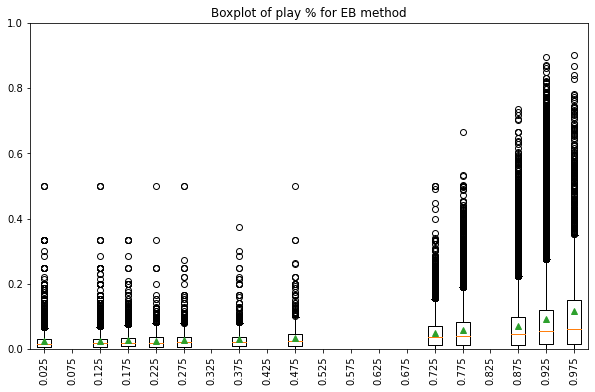

In [89]:
plt.figure(figsize=(10,6))
plt.boxplot(plays_datapoints_eb, labels=sorted(np.round(list(set(quantile_df.values)),3)), showmeans=True)
plt.xticks(rotation='vertical')
plt.ylim((0,1))
plt.title('Boxplot of play % for EB method')
_ = plt.show()

In [95]:
quality_datapoints_mix = [[] for _ in range(20)]
for l in data_dict[0.3]:
    chosen_vector = quality_datapoints_mix[modified_quantile_df[l[0]]]
        
    for lifespan in data_dict[0.3][l]:
        final_score = lifespan[-1] - lifespan[0]
        if np.sum(final_score) != 0:
            chosen_vector.append(final_score[0]/(final_score[0] + final_score[1]))
    

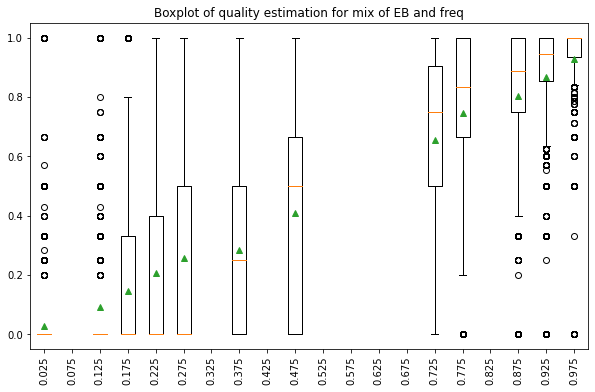

In [96]:
plt.figure(figsize=(10,6))
plt.boxplot(quality_datapoints_mix, labels=sorted(np.round(list(set(quantile_df.values)),3)), showmeans=True)
plt.xticks(rotation='vertical')
plt.title('Boxplot of quality estimation for mix of EB and freq')
_ = plt.show()

In [43]:
plays_datapoints_mix = [[] for _ in range(20)]
for l in data_dict[0.3]:
    chosen_vector = plays_datapoints_mix[modified_quantile_df[l[0]]]
        
    for lifespan in data_dict[0.3][l]:
        final_score = lifespan[-1]
        chosen_vector.append((final_score[0] + final_score[1] - np.sum(lifespan[0]))/lifespan.shape[0])
    

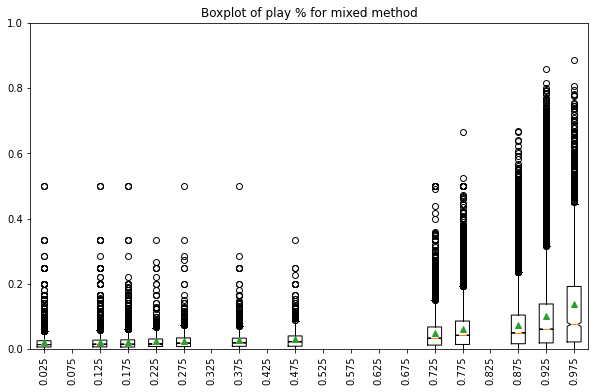

In [44]:
plt.figure(figsize=(10,6))
plt.boxplot(plays_datapoints_mix, labels=sorted(np.round(list(set(quantile_df.values)),3)), notch=True, showmeans=True)
plt.xticks(rotation='vertical')
plt.ylim((0,1))
plt.title('Boxplot of play % for mixed method')
_ = plt.show()

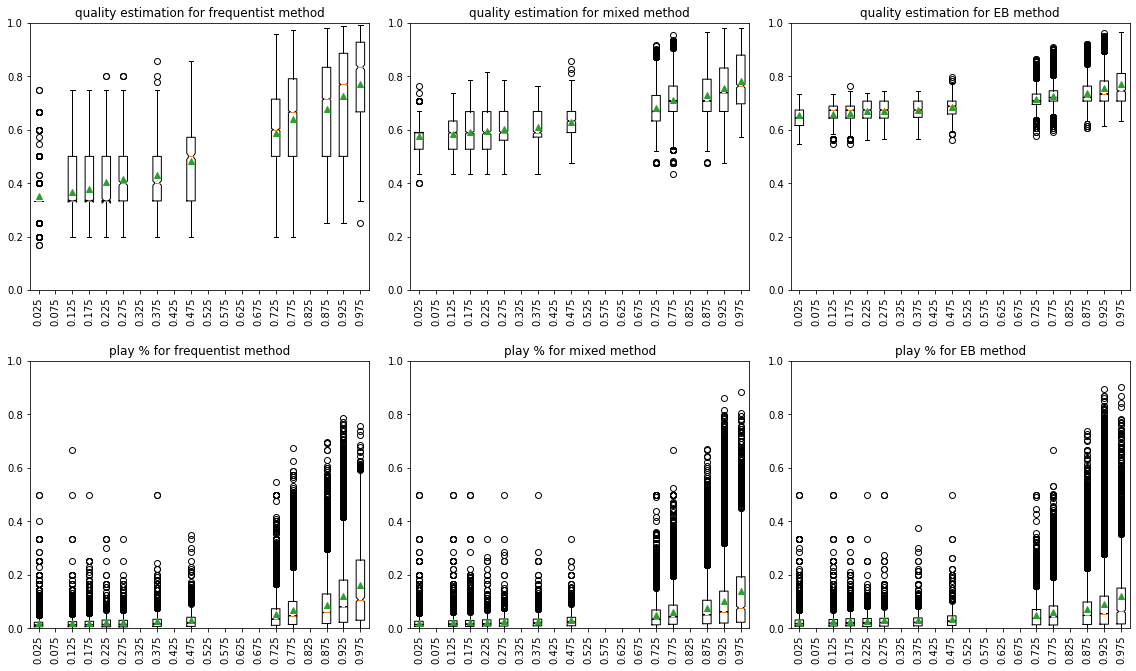

In [45]:
f, axes = plt.subplots(2,3)
f.set_size_inches(16,9)
f.tight_layout(h_pad=5)
datasets = [[quality_datapoints_freq, quality_datapoints_mix, quality_datapoints_eb], 
            [plays_datapoints_freq, plays_datapoints_mix, plays_datapoints_eb]]
plot_titles = [['quality estimation for frequentist method', 'quality estimation for mixed method', 'quality estimation for EB method'],
               ['play % for frequentist method', 'play % for mixed method', 'play % for EB method']]
for i in range(2):
    for j in range(3):
        plt.sca(axes[i,j])
        curr_dataset = datasets[i][j]
        plt.boxplot(curr_dataset, labels=sorted(np.round(list(set(quantile_df.values)),3)), notch=True, showmeans=True)
        plt.ylim((0,1))
        plt.xticks(rotation='vertical')
        plt.title(plot_titles[i][j])
        

In [46]:
# do a pareto curve of some efficiency-fairness tradeoff based on the prior you choose. Mean played quality as efficiency, variance of play % as fairness (or maybe Gini coefficient?)

## Step 4.5: Pareto curve demonstrating efficiency-equality tradeoff

In [54]:
# def gini_coeff(a):
#     """
#     Calculate the Gini coefficient of a distribution. Requires distribution to have non-negative entries, as well as
#     a positive sum.
#     """
    
# #     pair_array = np.split(np.array([item for item in itertools.product(a, repeat=2)]), os.cpu_count())
# #     p = Pool()
    
# #     numerator = np.sum(p.map(absolute_diff,pair_array))
#     numerator = 0
#     for pair in itertools.product(a, repeat=2):
#         numerator += absolute_diff(pair)
#     denominator = 2*np.sum(a)*a.shape[0]
#     return numerator/denominator

def gini_coeff(a):
    n = a.shape[0]
    counts = np.array(range(1,n+1))
    asum = np.sum(a)
    return 1/n*(n+1 - 2*((n+1)*np.sum(a) - a @ counts)/asum)

In [49]:
def average_arm_efficiency(data, video_df):
    total_plays = 0
    total_quality = 0
    for k in data:
        product_id = k if type(k) != tuple else k[0]
        num_plays = np.sum([a.shape[0] for a in data[k]])
        total_quality += num_plays*video_df[product_id]
        total_plays += num_plays
        
    return total_quality/total_plays
        

In [56]:
frequentist_gini = gini_coeff(np.concatenate(plays_datapoints_freq))

In [57]:
mixed_gini = gini_coeff(np.concatenate(plays_datapoints_mix))

In [58]:
eb_gini = gini_coeff(np.concatenate(plays_datapoints_eb))

In [64]:
frequentist_efficiency = average_arm_efficiency(data_dict[0.0], video_df)

In [65]:
mixed_efficiency = average_arm_efficiency(data_dict[0.3], video_df)

In [66]:
eb_efficiency = average_arm_efficiency(data_dict[1.0], video_df)

Text(0, 0.5, 'average product quality')

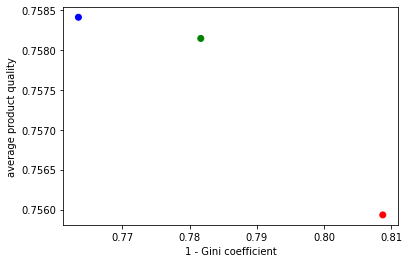

In [74]:
plt.scatter(x=[1-frequentist_gini, 1-mixed_gini, 1-eb_gini],
            y=[frequentist_efficiency, mixed_efficiency, eb_efficiency],
            c=['blue', 'green', 'red'])
plt.xlabel('1 - Gini coefficient')
plt.ylabel('average product quality')
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.legend()

In [75]:
# play around with efficiency measures, this one isn't telling the full story

# what are the aspects of our model that are simplifications of reality that needed to be defended?
# in particular, why is it ok that we make the simplifications that we do? Why do these simplifications not take away from the questions we want to answer?
# three-section approach: 
# What are our questions? (intro)
# What criteria does a model need to have to answer the question? (intro)
# What model fits the criteria? (model)
# What aren't we capturing? Why is this ok? (last paragraph of model explanation/final paragraph of paper)

In [76]:
np.concatenate(plays_datapoints_freq)

array([0.        , 0.00833333, 0.00793651, ..., 0.2606383 , 0.17391304,
       0.17741935])